# From Statistical Physics to Data-Driven Modelling with Applications to Quantitative Biology

Tutorial 6 : Online sparse principal component analysis of neural assemblies.

This tutorial is based on the same data set of Tutorial 3,  taken from the work:

Replay of rule-learning related neural patterns in the prefrontal cortex during sleep, A. Peyrache, K. Benchenane, M. Khamassi, S. I. Wiener, F. P. Battaglia, Nature Neuroscience, DOI:10.1038/nn.2337 (2009).

Solution Notebook SC RM FZ.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams["figure.figsize"] = (10, 8)
#plt.rcParams["font.size"] = 26

from scipy.sparse import coo_matrix
import numpy.matlib
from numpy import linalg as LA


Import data

In [2]:
data1=np.loadtxt('../Data/Dati_181014_maze.txt')
datatask=data1.astype(int)

Raster Plot of the first 10 seconds of the recorded activity

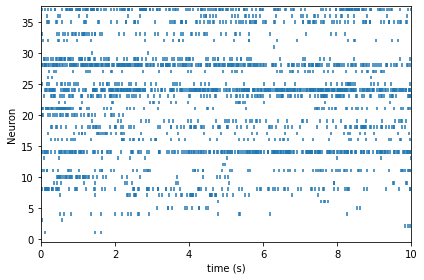

In [3]:
#Question 1: Raster Plot
raster=data1
tmin=np.min(raster[:,0])
tmax=np.max(raster[:,0])
plt.xlim([0,10])
plt.ylim([-0.5,37.5])
plt.vlines((raster[:,0]-tmin)/10000,raster[:,1]-0.3,raster[:,1]+0.3)
plt.xlabel('time (s)')
plt.ylabel('Neuron')
#plt.title('Raster plot')
plt.tight_layout()
plt.show()


# Principal component analysis (off-line learning) from Tutorial 3.

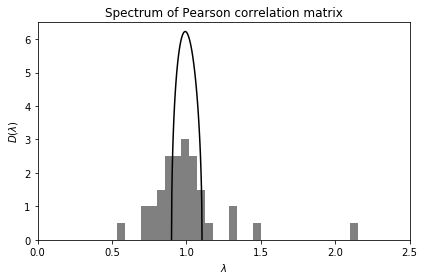

Number of eigenvalues > lp:  6


In [9]:
#Define Pearson matrix

#Pearson matrix
def Zscore(data):
    #time bin (in units of 0.1ms)
    dt=1000
    L=np.amax(data[:,1])
    Tmin=np.amin(data[:,0])
    Tmax=np.amax(data[:,0])
    T=Tmax-Tmin
    M=(T//dt)+1
    s=np.zeros((M,L),dtype=np.int)
    for k in range(len(data)):
        s[(data[k,0]-Tmin)//dt,data[k,1]-1]+=1
    #Alternative way, using sparse matrices
    #x=(data[:,0]-Tmin)//dt
    #y=data[:,1]-1
    #z=np.ones(np.size(data,0))
    #st=coo_matrix((z,(x,y)),dtype=np.int8,shape=(B,N))    
    #s=np.asarray(st)
    p=np.mean(s, axis=0, dtype=np.float64)
    sigma=np.sqrt(np.var(s, axis=0, dtype=np.float64, ddof=1))
    y=(s-p)/sigma
    return y.astype(np.float64)

#compute Pearson matrix for data and diagonalize it
Y=Zscore(datatask)
C=np.dot(Y.T,Y)/np.size(Y,0)
w, v = LA.eig(C)

#plot eigenvalue distribution
r=np.size(Y,1)/np.size(Y,0)
lp=(1+np.sqrt(r))**2
lm=(1-np.sqrt(r))**2
x=np.zeros((2,101))
for i in range(101):
    t=lm+(lp-lm)*i/100
    x[0,i]=t
    x[1,i]=np.sqrt((lp-t)*(t-lm))/(t*r)/(2*math.pi)
plt.hist(w, bins=30, normed=True, facecolor='grey')
plt.plot(x[0,:],x[1,:],'black')
plt.xlim([0,2.5])
plt.ylim([0,6.5])
plt.xlabel('$\lambda$')
plt.ylabel('$D(\lambda)$')
plt.title('Spectrum of Pearson correlation matrix')
plt.tight_layout()
#plt.savefig('PCA-task.pdf')
plt.show()


print('Number of eigenvalues > lp: ',len(np.where(w>lp)[0]))

2.1505329296818276 
 [-0.30575564  0.011962    0.00778311  0.00506386 -0.00252716 -0.01322397
 -0.09040398 -0.16575109 -0.27394546 -0.16083999 -0.16557683 -0.00855851
 -0.0309192   0.18770264  0.01711809 -0.10031741  0.13603484 -0.19069276
  0.03161871 -0.48857061 -0.42966552 -0.00084054 -0.07465402  0.09245687
 -0.10297825 -0.29401518  0.22419096 -0.06819083 -0.11757315  0.00927365
 -0.01872674 -0.09513298  0.01027532  0.05442999 -0.12028375  0.02597055
 -0.09338114]


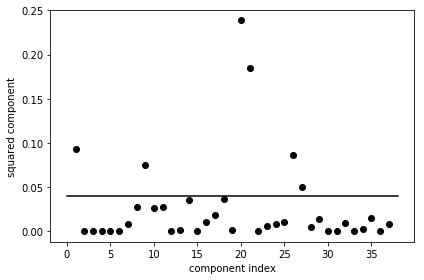

[ 1  9 20 21 26 27]


In [10]:
# Neurons that contribute the most to the largest eigenvector in the task 

v0=np.copy(v[:,0])
print(w[0],'\n',v0)
plt.plot(np.arange(1,v0.shape[0]+1),v0**2,'ko')
plt.plot([0,v0.shape[0]+1],[0.2**2,0.2**2],'black')
#plt.title('Squared components of largest eigenvector')
plt.xlabel('component index')
plt.ylabel('squared component')
plt.tight_layout()
#plt.savefig('taskcellassembly.pdf')
plt.show()
print(np.where(abs(v0)>0.2)[0]+1)

 Question 1: write the algotithm for the on-line learning of the Principal Component of the Pearson Correlation Matrix.

In [13]:
def online_PCA(Y, eta, Npass=1):
    L = np.shape(Y)[1]
    T = np.shape(Y)[0]
    J = np.random.normal(0,1,L)
    J = J/LA.norm(J)
    for n in range(Npass):
        for t in range(T):
            z=np.dot(J,Y[t,:])
            if (np.isnan(z)):
                print("Instability at step",t)
                break
            J+=eta*z*(Y[t,:]-z*J) 
    return J/LA.norm(J)

Question 2: Plot the scalar product between the principal component and its estimate with the online learning procedure of the previous question as a function of eta. 

Optimal eta 0.00029763514416313193


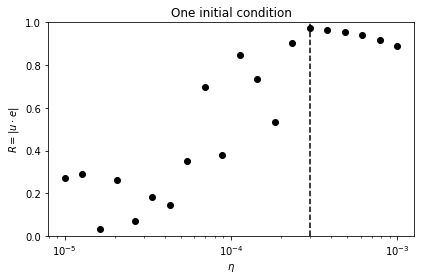

In [18]:
etav=np.logspace(-5,-3,20)
Nav=1
Rv=np.zeros(len(etav))
for rep in range(Nav):
    Rv+=abs(np.dot([online_PCA(Y,eta,1) for eta in etav],v0))
Rv/=Nav
etastar = etav[np.argmax(Rv)]
print('Optimal eta',etastar)
plt.semilogx(etav,Rv,'ko')
plt.semilogx([etastar, etastar], [0, 1], 'k--')
plt.ylim(0,1)
plt.title('One initial condition')
plt.xlabel('$\eta$')
plt.ylabel('$R=|u\cdot e|$')
#plt.text(1e-5, 0.9, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('Rvseta_1.pdf')
plt.show()


Question 3 verify Instability at large eta eg.eta=0.01.

In [22]:
online_PCA(Y,0.01,1)

Instability at step 1186


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Question 4: Plot the squared component of the  online principal component   and compare with the ones obtained for the offline principal component for eta=0.0004.

Total time 5.6344
Distance to principal component 0.9625798395085534


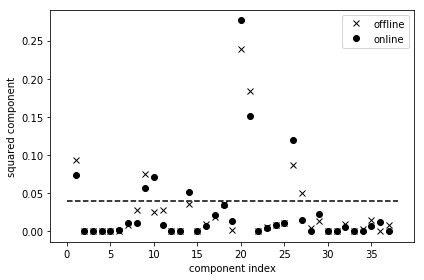

Offline learning: [ 1  9 20 21 26 27]
Online learning: [ 1  9 10 14 20 21 26]
Both: [ 1  9 20 21 26]


In [28]:
eta=0.0004
Npass=1
u0 = online_PCA(Y, eta, Npass)
print("Total time",eta*Npass*np.shape(Y)[0])
print("Distance to principal component",abs(np.dot(v0,u0)))
plt.plot(np.arange(1,v0.shape[0]+1),v0**2,'kx',label="offline")
plt.plot(np.arange(1,u0.shape[0]+1),u0**2,'ko',label="online")
plt.plot([0,v0.shape[0]+1],[0.2**2,0.2**2],'k--')
plt.legend()
#plt.title('Squared components of largest eigenvector')
plt.xlabel('component index')
plt.ylabel('squared component')
plt.tight_layout()
#plt.savefig('squared_comp.pdf')
plt.show()
print("Offline learning:",np.where(abs(v0)>0.2)[0]+1)
print("Online learning:",np.where(abs(u0)>0.2)[0]+1)
print("Both:",np.where((abs(u0)>0.2) & (abs(v0)>0.2))[0]+1)

Question 5: Write the code for the Online Sparse Principal Component Analysis.

In [26]:
def online_sparse_PCA(Y, eta, Jinit, Npass=1, gamma=0):
    L = np.shape(Y)[1]
    T = np.shape(Y)[0]
    J = np.copy(Jinit)
    for n in range(Npass):
        for t in range(T):
            z=np.dot(J,Y[t,:])
            if (np.isnan(z)):
                print("Instability at step",t)
                break
            J+=eta*( z*(Y[t,:]-z*J) - gamma*np.sign(J) )
    return J/LA.norm(J), LA.norm(J)    

Question 6: Discuss the dependence of the norm of the Online Sparse Principal Component  on the regularisation parameter γ, keeping fixed eta=0.0004, and identify the critical value γc at which the norm become zero.

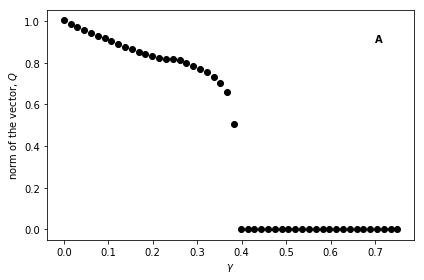

In [29]:
eta=0.0004
Npass=1
gammav=np.linspace(0.0,0.75,50)
q=[]
r=[]
for gamma in gammav:
    uapp, qapp = online_sparse_PCA(Y, eta, u0, Npass, gamma)
    rapp = abs(np.dot(uapp,v0))
    q.append(qapp)
    r.append(rapp)
plt.plot(gammav,q,'ko')
plt.xlabel('$\gamma$')
plt.ylabel('norm of the vector, $Q$')
plt.text(0.7, 0.9, 'A', fontweight='bold')
plt.legend()
plt.tight_layout()
#plt.savefig('Qvsgamma.pdf')
plt.show()

Plot the online sparse PCA for  γ=0.1,0.2,0.3. Compare with the results for online PCA and PCA. 

Total time 5.6344


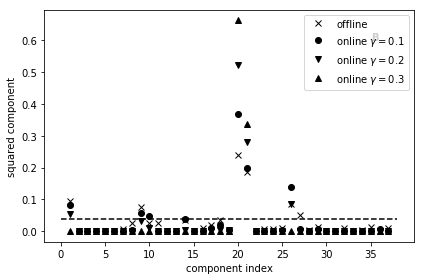

Offline PCA: [ 1  9 20 21 26 27]
Online sparse PCA gamma=0.1: [ 1  9 10 20 21 26]
Online sparse PCA gamma=0.2: [ 1 20 21 26]
Online sparse PCA gamma=0.3: [20 21]


In [31]:
eta=0.0004
Npass=1
u0sp1, q = online_sparse_PCA(Y, eta, u0, Npass, 0.1)
u0sp2, q = online_sparse_PCA(Y, eta, u0, Npass, 0.2)
u0sp3, q = online_sparse_PCA(Y, eta, u0, Npass, 0.3)
print("Total time",eta*Npass*np.shape(Y)[0])
plt.plot(np.arange(1,v0.shape[0]+1),v0**2,'kx',label="offline")
plt.plot(np.arange(1,v0.shape[0]+1),u0sp1**2,'ko',label="online $\gamma=0.1$")
plt.plot(np.arange(1,v0.shape[0]+1),u0sp2**2,'kv',label="online $\gamma=0.2$")
plt.plot(np.arange(1,v0.shape[0]+1),u0sp3**2,'k^',label="online $\gamma=0.3$")
plt.plot([0,v0.shape[0]+1],[0.2**2,0.2**2],'k--')
#plt.title('Squared components of largest eigenvector')
plt.legend()
plt.xlabel('component index')
plt.ylabel('squared component')
plt.text(35, 0.6, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('uvsgamma.pdf')
plt.show()
print("Offline PCA:",np.where(abs(v0)>0.2)[0]+1)
print("Online sparse PCA gamma=0.1:",np.where(abs(u0sp1)>0.2)[0]+1)
print("Online sparse PCA gamma=0.2:",np.where(abs(u0sp2)>0.2)[0]+1)
print("Online sparse PCA gamma=0.3:",np.where(abs(u0sp3)>0.2)[0]+1)


Question 8 (Bonus) repeat the online PCA  learning procedure with a number of passes Npass =25 over the data set and compare with PCA.

Online PCA with Npass=25

Total time 14.086
Distance to principal component 0.999122039420215


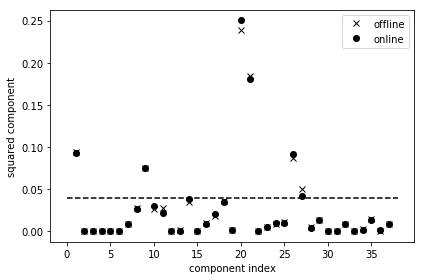

Offline learning: [ 1  9 20 21 26 27]
Online learning: [ 1  9 20 21 26 27]
Both: [ 1  9 20 21 26 27]


In [37]:
eta=0.00004
Npass=25
ustst = online_PCA(Y, eta, Npass)
print("Total time",eta*Npass*np.shape(Y)[0])
print("Distance to principal component",abs(np.dot(v0,ustst)))
plt.plot(np.arange(1,v0.shape[0]+1),v0**2,'kx',label="offline")
plt.plot(np.arange(1,ustst.shape[0]+1),ustst**2,'ko',label="online")
plt.plot([0,v0.shape[0]+1],[0.2**2,0.2**2],'k--')
plt.legend()
#plt.title('Squared components of largest eigenvector')
plt.xlabel('component index')
plt.ylabel('squared component')
plt.tight_layout()
#plt.savefig('bonus_squared_comp.pdf')
plt.show()
print("Offline learning:",np.where(abs(v0)>0.2)[0]+1)
print("Online learning:",np.where(abs(ustst)>0.2)[0]+1)
print("Both:",np.where((abs(ustst)>0.2) & (abs(v0)>0.2))[0]+1)

Online Sparse PCA with Npass=25

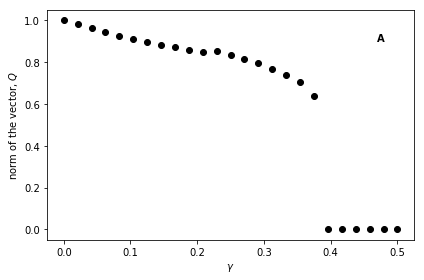

In [36]:
gammav=np.linspace(0.0,0.5,25)
q=[]
r=[]
for gamma in gammav:
    uapp, qapp = online_sparse_PCA(Y, eta, ustst, Npass, gamma)
    rapp = abs(np.dot(uapp,v0))
    q.append(qapp)
    r.append(rapp)
plt.plot(gammav,q,'ko')
plt.xlabel('$\gamma$')
plt.ylabel('norm of the vector, $Q$')
plt.text(0.47, 0.9, 'A', fontweight='bold')
plt.tight_layout()
#plt.savefig('bonus_Qvsgamma.pdf')
plt.legend()
plt.show()

Total time 14.086


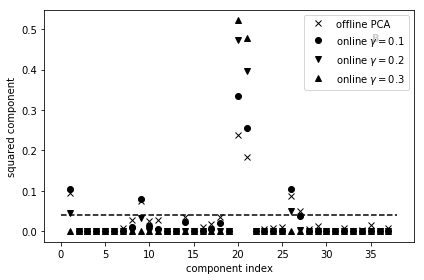

Offline PCA: [ 1  9 20 21 26 27]
Online sparse PCA gamma=0.1: [ 1  9 20 21 26]
Online sparse PCA gamma=0.2: [ 1 20 21 26]
Online sparse PCA gamma=0.3: [20 21]


In [38]:
u1sp1, q = online_sparse_PCA(Y, eta, ustst, Npass, 0.1)
u1sp2, q = online_sparse_PCA(Y, eta, ustst, Npass, 0.2)
u1sp3, q = online_sparse_PCA(Y, eta, ustst, Npass, 0.3)
print("Total time",eta*Npass*np.shape(Y)[0])
plt.plot(np.arange(1,v0.shape[0]+1),v0**2,'kx',label="offline PCA")
plt.plot(np.arange(1,v0.shape[0]+1),u1sp1**2,'ko',label="online $\gamma=0.1$")
plt.plot(np.arange(1,v0.shape[0]+1),u1sp2**2,'kv',label="online $\gamma=0.2$")
plt.plot(np.arange(1,v0.shape[0]+1),u1sp3**2,'k^',label="online $\gamma=0.3$")
plt.plot([0,v0.shape[0]+1],[0.2**2,0.2**2],'k--')
#plt.title('Squared components of largest eigenvector')
plt.legend()
plt.xlabel('component index')
plt.ylabel('squared component')
plt.text(35, 0.47, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('bonus_uvsgamma.pdf')
plt.show()
print("Offline PCA:",np.where(abs(v0)>0.2)[0]+1)
print("Online sparse PCA gamma=0.1:",np.where(abs(u1sp1)>0.2)[0]+1)
print("Online sparse PCA gamma=0.2:",np.where(abs(u1sp2)>0.2)[0]+1)
print("Online sparse PCA gamma=0.3:",np.where(abs(u1sp3)>0.2)[0]+1)

